# Chapter 14: Portfolio Construction

Implementation is the efficient translation of research into portfolios.  Good implementation can't help poor research but poor implementation can waylay good research.

Portfolio construction requires several inputs
- current portfolio
- alphas
- covariance estimates
- transaction cost estimates
- active risk aversion

Of these we can only measure the current portfolio with good certainty.    Implementation schemes address

- a) What portfolio we choose given inputs
- b) What procedures we can use to make the portfolio construction process robust in the presence of noisy inputs

## Summary

- Implementation schemes are, in part, safeguards against poor research
- With alpha analysis, the alphas can be adjusted so that they are in line with the manager's desires for risk control and anticipated sources of value add
- Portfolio construction techniques including screening, stratified sampling, linear programming and quadratic programming.  Given sufficiently accurate risk estimates, the quadratic programming technique most consistently achieves high value add
- For most active institutional portfolio managers, building portfolios using alternative risk measures greatly increases the effort (and the chance of error) without greatly affecting the result.
- Manages running separate accounts for multiple clients can control dispersion, but can't eliminate it


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from scipy.optimize import minimize
%matplotlib inline

## Alphas and Portfolio Construction

Most portfolios will have constructs (e.g. can't take short positions, limit amount of cash in portfolios etc.)

We can use a modified set of alphas with the appropriate level of risk aversion using

$$ \boxed{ \alpha^{'} = \left( \frac{IR}{\psi_{p}^{*}} \right) \cdot \mathbf{V} \cdot \mathbf{h_{PA}^{*}} } $$

where the active risk aversion is

$$ \boxed{ \lambda_{A}^{'} = \frac{IR}{2 \cdot \psi_{P}^{*}} }$$

We can replace any portfolio construction process, regardless of its sophistication, by a process that first refines the alphas and then uses a simple unconstrained mean/variance optimisation to determine the active positions.

## Alpha Analysis

**Scale the Alphas**

- Alphas have a natural structure ($\alpha = volatility \cdot IC \cdot score$)
- This structure has a natural scale (we expect IC and residual risk (volatility) for a set of alphas to be approx constant - with mean 0, std dev 1)
- This implies alphas should have mean 0, standard dev Std{α} ~ volatility ⋅ IC

**Trim Alpha Outliers**

- trim extreme values / large positive / negative alphas can have undue influence on the portfolio

**Neutralisation**

- removing unwanted biases from the alphas
- if initial alphas imply an alpha for the benchmark, neutralisation process reenters the alphas to remove the benchmark alpha

**Benchmark and Cash-Neutral Alphas**

- Simplest neutralisation is to make the alphas benchmark neutral
- Also want to make the alphas cash neutral

**Risk-Factor Neutral Alphas**

The multiple factor approach to portfolio analysis separates returns along multiple dimensions.  The alphas can be neutralised to those dimensions that are risk factors

- e.g. Eg ensure that the portfolio contains no active bets on industrial sectors or on a size factor

## Transaction Costs

Accurate estimation of transaction costs is nearly as important as accurate forecasts of exception return.

The problem now becomes 2-dimensional balancing:
- Alpha
- Active Risk / Risk Aversion &
- Transaction Costs



## Practical Details

Repeating the result from Chapter 5

The optimal level of residual risk $\omega^{*}$ which maximizes $VA[\omega_{p}]$ is

$$ \boxed{ \omega^{*} = \frac{IR}{2 \cdot \lambda_{R}} }$$

In terms of the active risk aversion $\lambda_{A}$ we have the equivalent result

$$ \boxed{ \lambda_{A} = \frac{IR}{2 \cdot \psi_{P}} }$$

## Portfolio Revisions

How often should you revise your portfolio ?   Ideally whenever you receive new information.

In general even with accurate transaction cost estimates, as the horizon of the forecast alphas decrease we expect them to contain larger amounts of noise.  The returns, in turn, become noiser with shorter horizons.  Re-balancing for very short horizons will involve frequent reactions to noise, not signal.  The transaction cost themselves stay the same regardless of reacting to signal or noise.

The trade-off between alpha, risk and return is difficult to ascertain due to the importance of the horizon.  If we expect to realize alpha over some horizon we must hen amortise the transaction costs over that horizon.

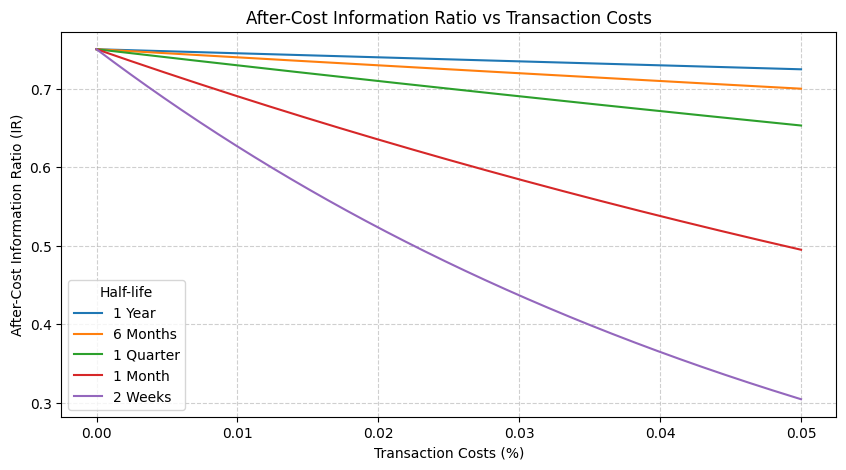

In [2]:
IR0 = 0.75  # Initial Information Ratio
transaction_costs = np.linspace(0, 0.05, 500)  # Transaction costs from 0 to 0.5%

half_lives = {
    "1 Year": 1,
    "6 Months": 0.5,
    "1 Quarter": 0.25,
    "1 Month": 1 / 12,
    "2 Weeks": 1 / 26
}

ir_after_costs = {}
for label, half_life in half_lives.items():
    delta = 0.5 ** (transaction_costs / half_life)  # Decay factor
    ir_after_costs[label] = IR0 * delta           # After-cost IR

plt.figure(figsize=(10, 5))
for label, ir_values in ir_after_costs.items():
    plt.plot(transaction_costs, ir_values, label=f"{label}")

plt.title("After-Cost Information Ratio vs Transaction Costs")
plt.xlabel("Transaction Costs (%)")
plt.ylabel("After-Cost Information Ratio (IR)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Half-life")
plt.show()

## Techniques for Portfolio Construction

Techniques for portfolio construction include:

- Screens
- Stratification
- Linear Programming
- Quadratic Programming

Our criteria for evaluation is high alpha, low active risk and low transaction costs.  Our measure of value add is

$$ \boxed{ \alpha_{P} - \lambda_{A} \cdot \psi_{P}^{2} - TC }$$

**Screens:**

Screens are the simplest - for example:

- Rank the stocks by alpha
- Choose the first e.g. 50 stocks
- Equal-weight (or capitalization-weight) the stocks

And can also be used for re-balancing.  e.g. For 200 stocks divide into top 40, next 50 and remaining 100.  (Buy / Hold / Sell)

Their attractiveness is simplicity / easy to understand.  However, the ignore all information in the alphas apart from ranking and do not protect against biases in the alphas.

**Stratification:**

Stratification is a more sophisticated version of screens.  The stocks are divided into categories (generally exclusive) and then the categories are combined to form the portfolio.  The idea is to obtain risk control by balancing the holdings in each category.

**Linear Programming:**

The linear programming approach characterises stocks along dimensions or risk (e.g. industry size, volatility and beta).  We characterise each stock along all of these dimensions and the linear program then attempts to build portfolios that are neutral (reasonably close to the benchmark portfolio) along those dimensions used for risk control.

**Quadratic Programming:**

Constraint optimization in addition to linear programming where the objective function is quadratic in nature.

One needs to be careful with quadratic programming as the solution can be sensitive to the inputs (esp noisy data).





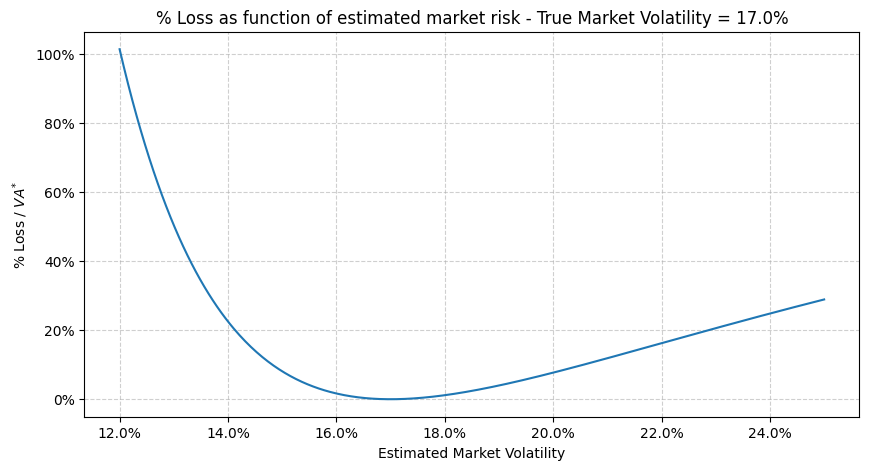

In [3]:
true_market_volatility = 0.17
est_market_volatility = np.linspace(0.12, 0.25, 500)  # Transaction costs from 0 to 0.5%

def perceived_vs_actual_ratio(actual, perceived):
    return (1- (actual / perceived) ** 2) ** 2

plt.figure(figsize=(10, 5))
plt.plot(est_market_volatility, perceived_vs_actual_ratio(true_market_volatility, est_market_volatility))

plt.title(f"% Loss as function of estimated market risk - True Market Volatility = {true_market_volatility:.1%}")
plt.xlabel("Estimated Market Volatility")
plt.ylabel("% Loss / $VA^{*}$")
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**Note** example above -volatility estimates within 1 % of true market volatility will not hurt the value add very much but as the estimation error exceeds 3% the effect on the value add becomes significant.

**Below** is a simple optimization example using scipy

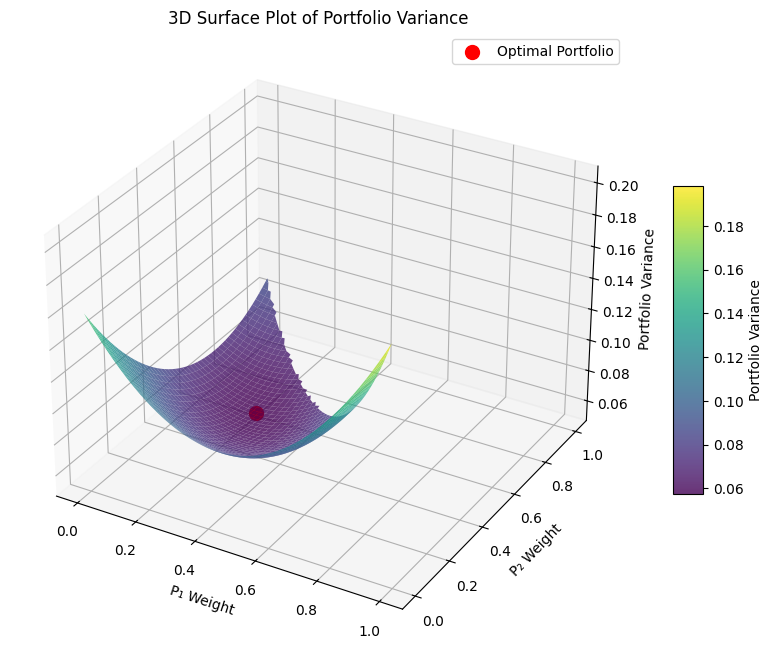

Optimal Portfolio Weights: ['0.236', '0.536', '0.228']
Optimal Portfolio Variance: 0.057


In [4]:
# Optimization  Example
# Input data
expected_returns = np.array([0.12, 0.18, 0.14])  # Expected returns
cov_matrix = np.array([
    [0.20, 0.01, 0.02],
    [0.01, 0.09, 0.03],
    [0.02, 0.03, 0.16]
])  # Covariance matrix
target_return = 0.15  # Target portfolio return

num_assets = len(expected_returns)

# Objective function: Minimize portfolio variance
def portfolio_variance(weights):
    return weights.T @ cov_matrix @ weights

# Constraints
constraints = [
    {"type": "eq", "fun": lambda w: np.sum(w) - 1},  # Weights must sum to 1
    {"type": "ineq", "fun": lambda w: w.T @ expected_returns - target_return}  # Target return
]

# Bounds for weights: No short selling (weights >= 0)
bounds = [(0, 1) for _ in range(num_assets)]

# Initial guess: Equal weights
initial_weights = np.ones(num_assets) / num_assets

# Solve the optimization problem
result = minimize(portfolio_variance, initial_weights, bounds=bounds, constraints=constraints)

# Extract optimal weights and variance
optimal_weights = result.x if result.success else None
optimal_variance = result.fun if result.success else None

# Generate grid of weights for plotting
w1 = np.linspace(0, 1, 100)  # Weight for Asset 1
w2 = np.linspace(0, 1, 100)  # Weight for Asset 2
W1, W2 = np.meshgrid(w1, w2)  # Create a grid
variances = np.zeros_like(W1)

# Calculate variances for all combinations of weights
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        weight1, weight2 = W1[i, j], W2[i, j]
        weight3 = 1 - weight1 - weight2  # Ensure weights sum to 1
        if 0 <= weight3 <= 1:  # Only valid combinations
            portfolio_weights = np.array([weight1, weight2, weight3])
            variances[i, j] = portfolio_variance(portfolio_weights)
        else:
            variances[i, j] = np.nan  # Mark invalid combinations

# plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(W1, W2, variances, cmap='viridis', edgecolor='none', alpha=0.8)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Portfolio Variance')

# Highlight optimal solution
if optimal_weights is not None:
    ax.scatter(optimal_weights[0], optimal_weights[1], optimal_variance, color='red', label='Optimal Portfolio', s=100)

ax.set_xlabel('P₁ Weight')
ax.set_ylabel('P₂ Weight')
ax.set_zlabel('Portfolio Variance')
ax.set_title('3D Surface Plot of Portfolio Variance')
if optimal_weights is not None:
    ax.legend()
plt.show()

# Display results
if optimal_weights is not None:
    print(f'Optimal Portfolio Weights: {[f"{x:.3f}" for x in optimal_weights]}')
    print(f'Optimal Portfolio Variance: {optimal_variance:.3f}')
else:
    print("Optimization failed:", result.message)